In [41]:
%matplotlib inline

In [82]:
import os
import zipfile
from pathlib import Path
import requests
import matplotlib.pyplot as plt
from cycler import cycler
from tqdm import tqdm
import pandas as pd 
import geopandas as gpd
from shapely.geometry import Point

In [83]:
plt.style.use("bmh")
plt.rcParams['axes.prop_cycle'] = cycler(color=plt.get_cmap('Set1').colors)
plt.rcParams["figure.figsize"] = (16, 4)
plt.rcParams["font.family"] = "IPAPGothic"

In [19]:
gm_jpn_url = 'http://www1.gsi.go.jp/geowww/globalmap-gsi/download/data/gm-japan/gm-jpn-all_u_2_2.zip'
data_dir = Path(os.getcwd())/'data'

In [6]:
r = requests.get(gm_jpn_url, stream=True)
filename = data_dir/'gm-jpn.zip'

with open(filename, 'wb') as f:
    for chunk in tqdm(r.iter_content(chunk_size=1024)):
        if chunk:
            f.write(chunk)
            f.flush()

9311it [00:07, 1195.73it/s]


In [11]:
zfile = zipfile.ZipFile(filename)
zfile.extractall(data_dir)

In [20]:
os.listdir(data_dir/'gm-jpn-all_u_2_2')

['trans_jpn.met',
 'builtupp_jpn.prj',
 'coastl_jpn.shx',
 'polbnda_jpn.dbf',
 'miscl_jpn.dbf',
 'rstatp_jpn.dbf',
 'raill_jpn.shp',
 'coastl_jpn.shp',
 'inwatera_jpn.prj',
 'miscp_jpn.dbf',
 'raill_jpn.shx',
 'polbndl_jpn.prj',
 'roadl_jpn.prj',
 'portp_jpn.prj',
 'ferryl_jpn.prj',
 'airp_jpn.dbf',
 'builtupa_jpn.dbf',
 'airp_jpn.shp',
 'builtupa_jpn.shp',
 'riverl_jpn.prj',
 'airp_jpn.shx',
 'builtupa_jpn.shx',
 'miscl_jpn.shx',
 'miscp_jpn.shp',
 'rstatp_jpn.shx',
 'coastl_jpn.dbf',
 'polbnda_jpn.shx',
 'rstatp_jpn.shp',
 'miscl_jpn.shp',
 'miscp_jpn.shx',
 'raill_jpn.dbf',
 'polbnda_jpn.shp',
 'builtupp_jpn.shp',
 'inwatera_jpn.shx',
 'raill_jpn.prj',
 'builtupp_jpn.shx',
 'coastl_jpn.prj',
 'inwatera_jpn.shp',
 'ferryl_jpn.shx',
 'polbndl_jpn.shp',
 'roadl_jpn.shp',
 'riverl_jpn.dbf',
 'portp_jpn.shp',
 'pop_jpn.met',
 'ferryl_jpn.shp',
 'polbndl_jpn.shx',
 'roadl_jpn.shx',
 'portp_jpn.shx',
 'hydro_jpn.met',
 'riverl_jpn.shx',
 'airp_jpn.prj',
 'ferryl_jpn.dbf',
 'builtupa_jpn.pr

In [34]:
query = """
#standardSQL
WITH safe AS (
  SELECT
    NET.SAFE_IP_FROM_STRING(contributor_ip) AS ip,  
    LENGTH(NET.SAFE_IP_FROM_STRING(contributor_ip)) AS len 
  FROM
      `publicdata.samples.wikipedia` 
  WHERE contributor_ip IS NOT NULL
),
wiki_ips AS (
  SELECT 
    NET.IPV4_TO_INT64(ip) AS clientIpNum,
    TRUNC(NET.IPV4_TO_INT64(ip)/(256*256)) AS classB_
  FROM safe 
  WHERE ip IS NOT NULL 
    AND len = 4
)
SELECT MAX(b.longitude) AS longitude, MAX(b.latitude) AS latitude, b.city, COUNT(*) AS count 
FROM wiki_ips  
LEFT JOIN `fh-bigquery.geocode.geolite_city_bq_b2b`AS b ON wiki_ips.classB_ = b.classB
WHERE wiki_ips.clientIpNum BETWEEN b.startIpNum AND b.endIpNum
GROUP BY b.city 
HAVING MAX(b.country) = 'JP'
;
"""

In [35]:
df = pd.read_gbq(query, project_id=os.environ.get('PROJECT_ID'), dialect='standard')

Text(0.5,1,'IP Count')

/Users/yutaro_ikeda/.pyenv/versions/3.6.5/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['IPAPGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


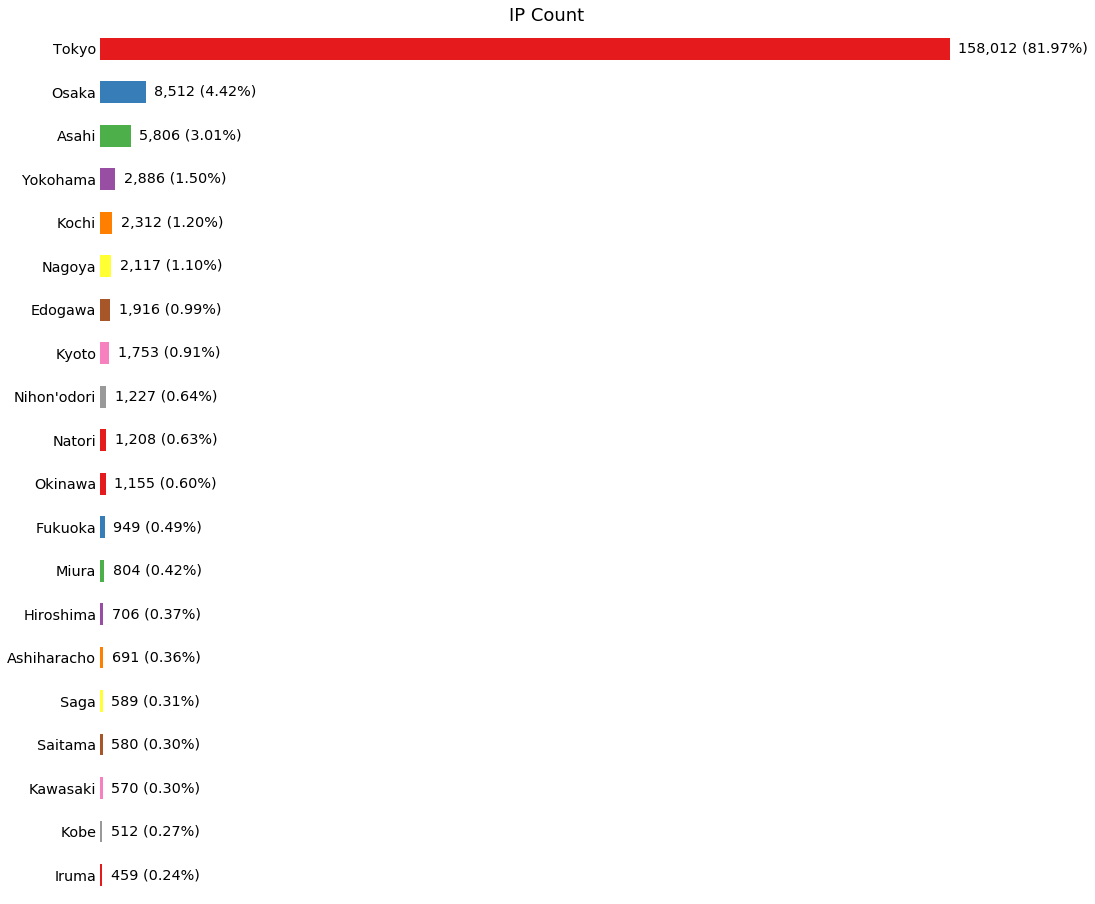

In [84]:
plt.figure(figsize=(16, 16))

tmp_data = df[['city', 'count']].sort_values('count', ascending=False).head(20).set_index('city')['count']
ax = tmp_data.plot(kind='barh')
data = tmp_data.values.tolist()

ax.tick_params(bottom=False, left=False, labelbottom=False)
ax.tick_params(axis='y', labelsize='x-large')
ax.set_ylabel('')

vmax = max(data)
sum_ = sum(data)
for i, v in enumerate(data):
    ax.text(v+vmax*0.01, i, f'{v:,} ({v/sum_:.2%})', fontsize='x-large', va='center')

plt.gca().invert_yaxis()
ax.grid(False)
ax.patch.set_visible(False)
[spine.set_visible(False) for spine in ax.spines.values()]
ax.set_title('IP Count', fontsize=18)

In [70]:
gdf_jpn = gpd.read_file(str(data_dir/'gm-jpn/gm-jpn-all_u_2_2/polbnda_jpn.shp'))

In [74]:
df['coordinates'] = list(zip(df['longitude'].astype(float), df['latitude'].astype(float)))
df['coordinates'] = df['coordinates'].apply(Point)
gdf = gpd.GeoDataFrame(df, geometry='coordinates')

/Users/yutaro_ikeda/.pyenv/versions/3.6.5/lib/python3.6/site-packages/geopandas/plotting.py:389: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  "(for consistency with pandas)", FutureWarning)
/Users/yutaro_ikeda/.pyenv/versions/3.6.5/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['IPAPGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


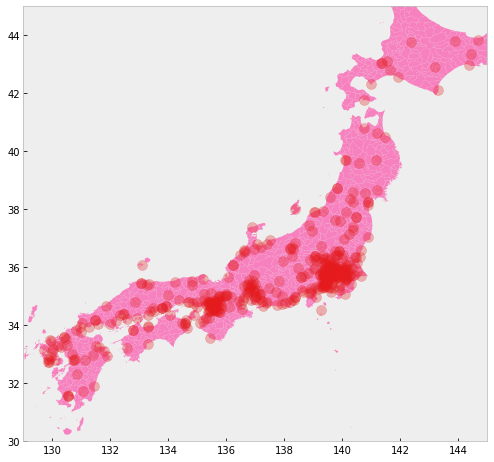

In [117]:
fig, axes = plt.subplots(figsize=(24, 8))
gdf_jpn.plot(color='C7', axes=axes)
gdf.plot(axes=axes, alpha=.3, color='C0', markersize=100)
plt.xlim(129, 145)
plt.ylim(30, 45)
plt.grid(False)